In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import keras
from keras_unet.models import custom_unet
from sklearn.model_selection import train_test_split

2023-03-03 22:05:22.056953: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
/home/jiehyun.kim001/miniconda3/envs/O/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [3]:
import tensorflow as tf

In [4]:
gpu_avail = tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2023-03-03 22:05:27.023973: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-03 22:05:27.026314: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-03-03 22:05:27.153199: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:47:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-03-03 22:05:27.153243: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-03-03 22:05:27.168258: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] 

In [5]:
gpu_avail

True

In [6]:
DATAPATH = '/raid/mpsych/CACTAS/DATA/ESUS/'
images_file = os.path.join(DATAPATH, 'image.npy')
labels_file = os.path.join(DATAPATH, 'label.npy')

In [7]:
images = np.load(images_file)
labels = np.load(labels_file)

In [8]:
images.ndim, labels.ndim

(3, 3)

In [9]:
# full dataset does not have the last channel
images = images.reshape(images.shape[0],images.shape[1],images.shape[2],1)
labels = labels.reshape(labels.shape[0],labels.shape[1],labels.shape[2],1)

In [10]:
p = np.random.permutation(len(images))

In [11]:
images = images[p]
labels = labels[p]

In [12]:
images = images.astype(np.float64)
labels = labels.astype(np.float64)

In [13]:
for i in range(images.shape[0]):
    
    images[i] = (images[i] - images[i].min()) / (images[i].max() - images[i].min()) # normalize individually
    

In [14]:
images.shape

(14893, 512, 512, 1)

In [15]:
labels.shape

(14893, 512, 512, 1)

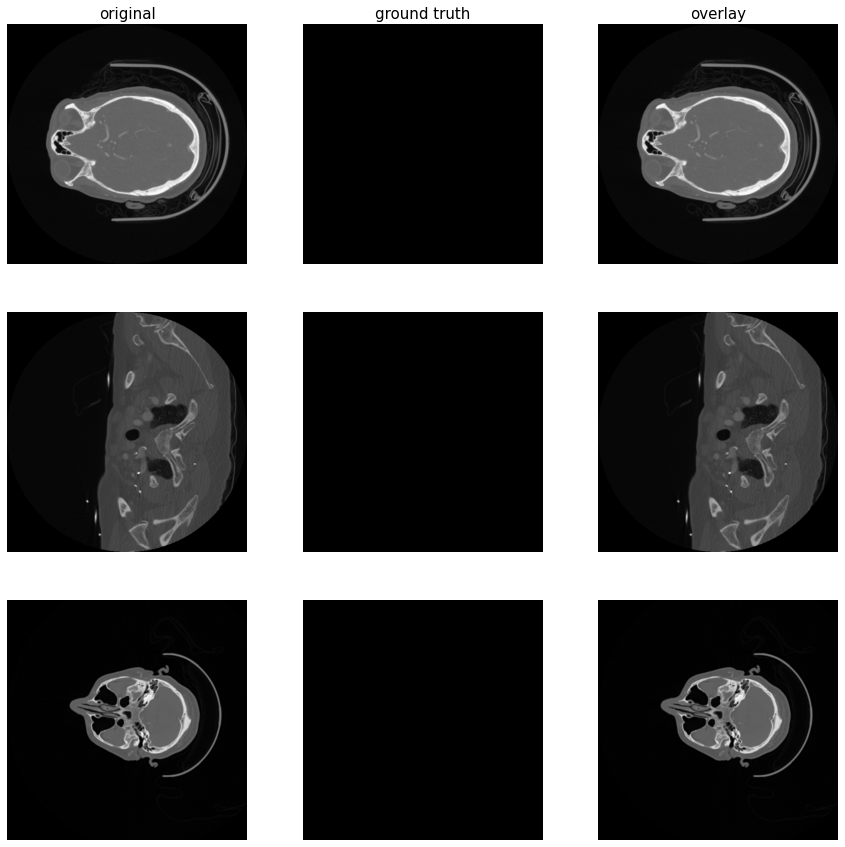

In [16]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=images, mask_imgs=labels, nm_img_to_plot=3, figsize=5)

In [14]:
#X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=0)

In [17]:
import json

In [18]:
with open("images_data_v2.json", "r") as fp:
    image_data = json.load(fp)
with open("labels_data_v2.json", "r") as fp:
    label_data = json.load(fp)

In [19]:
image_data['82']

12029

In [20]:
label_data['82']

12029

In [21]:
X_train = images[0:image_data['82']]
y_train = labels[0:label_data['82']]
X_val = images[image_data['82']:]
y_val = labels[label_data['82']:]

In [22]:
from keras_unet_collection import models, losses
import torch

model = models.swin_unet_2d((512, 512, 1), filter_num_begin=64,
                               n_labels=1, depth=4, stack_num_down=4, stack_num_up=4,
                               patch_size=(4, 4), num_heads=[4, 8, 16, 16],
                               window_size=[4, 2, 2, 2], num_mlp=512, 
                               output_activation='Sigmoid', shift_window=True, name='swin_unet')

#Softmax

2023-03-03 22:06:15.458998: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:47:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-03-03 22:06:15.463900: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 0
2023-03-03 22:06:15.466592: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:47:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-03-03 22:06:15.471480: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 0
2023-03-03 22:06:15.471521: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-03-03 22:06:15.471526: I tensorflow/core/common_runtime/gp

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [23]:
model.summary()

Model: "swin_unet_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
patch_extract (patch_extract)   (None, 16384, 16)    0           input_1[0][0]                    
__________________________________________________________________________________________________
patch_embedding (patch_embeddin (None, 16384, 64)    1049664     patch_extract[0][0]              
__________________________________________________________________________________________________
swin_transformer_block (SwinTra (None, 16384, 64)    83460       patch_embedding[0][0]            
____________________________________________________________________________________

In [24]:
from tensorflow.keras import optimizers
from keras_unet.metrics import iou, iou_thresholded, dice_coef
from keras_unet_collection import losses

In [25]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr = 0.001),
              metrics=[iou, iou_thresholded])

/home/jiehyun.kim001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [26]:
history = model.fit(X_train, 
                    y_train, 
                    batch_size=16,
                    epochs=100,
                    validation_data=(X_val, y_val))

2023-03-03 22:06:38.952257: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-03-03 22:06:38.973170: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2245645000 Hz


Epoch 1/100


2023-03-03 22:07:03.424870: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-03-03 22:07:04.417250: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-03-03 22:07:04.417617: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-03-03 22:07:04.556267: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-03-03 22:07:05.359600: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2023-03-03 22:07:06.366999: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2023-03-03 22:07:06.367025: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2023-03-03 22:07:06.36741

752/752 [==============================] - 636s 808ms/step - loss: 118.4950 - iou: 0.3624 - iou_thresholded: 0.3710 - val_loss: 5.2258 - val_iou: 0.3153 - val_iou_thresholded: 0.3159
Epoch 2/100
752/752 [==============================] - 598s 795ms/step - loss: 0.9377 - iou: 0.0935 - iou_thresholded: 0.0943 - val_loss: 0.0057 - val_iou: 0.0091 - val_iou_thresholded: 0.0097
Epoch 3/100
752/752 [==============================] - 598s 795ms/step - loss: 0.0061 - iou: 0.0734 - iou_thresholded: 0.0764 - val_loss: 0.0024 - val_iou: 0.1296 - val_iou_thresholded: 0.1621
Epoch 4/100
752/752 [==============================] - 601s 800ms/step - loss: 0.0017 - iou: 0.0341 - iou_thresholded: 0.0691 - val_loss: 0.0012 - val_iou: 0.1341 - val_iou_thresholded: 0.3577
Epoch 5/100
752/752 [==============================] - 598s 795ms/step - loss: 9.4645e-04 - iou: 0.0151 - iou_thresholded: 0.1034 - val_loss: 6.5872e-04 - val_iou: 0.0069 - val_iou_thresholded: 0.0919
Epoch 6/100
752/752 [================

Epoch 43/100
752/752 [==============================] - 599s 796ms/step - loss: 0.0013 - iou: 0.0164 - iou_thresholded: 0.0277 - val_loss: 0.0013 - val_iou: 0.0276 - val_iou_thresholded: 0.0438
Epoch 44/100
752/752 [==============================] - 598s 795ms/step - loss: 0.0012 - iou: 0.0307 - iou_thresholded: 0.0485 - val_loss: 8.3977e-04 - val_iou: 0.0451 - val_iou_thresholded: 0.1395
Epoch 45/100
752/752 [==============================] - 598s 796ms/step - loss: 6.4932e-04 - iou: 0.0176 - iou_thresholded: 0.0623 - val_loss: 0.0014 - val_iou: 0.0089 - val_iou_thresholded: 0.0239
Epoch 46/100
752/752 [==============================] - 601s 799ms/step - loss: 5.5992e-04 - iou: 0.0244 - iou_thresholded: 0.1036 - val_loss: 9.6416e-04 - val_iou: 0.0104 - val_iou_thresholded: 0.0355
Epoch 47/100
752/752 [==============================] - 598s 795ms/step - loss: 7083.4419 - iou: 0.0579 - iou_thresholded: 0.0583 - val_loss: 1.8237 - val_iou: 0.0033 - val_iou_thresholded: 0.0033
Epoch 48/10

Epoch 85/100
752/752 [==============================] - 598s 795ms/step - loss: 65.8543 - iou: 0.0702 - iou_thresholded: 0.0702 - val_loss: 44.6662 - val_iou: 0.0037 - val_iou_thresholded: 0.0037
Epoch 86/100
752/752 [==============================] - 599s 796ms/step - loss: 179.5319 - iou: 0.0505 - iou_thresholded: 0.0505 - val_loss: 33.7279 - val_iou: 0.0085 - val_iou_thresholded: 0.0085
Epoch 87/100
752/752 [==============================] - 599s 797ms/step - loss: 68.0425 - iou: 0.0555 - iou_thresholded: 0.0555 - val_loss: 30.2426 - val_iou: 0.1408 - val_iou_thresholded: 0.1408
Epoch 88/100
752/752 [==============================] - 601s 799ms/step - loss: 16.0966 - iou: 0.0190 - iou_thresholded: 0.0190 - val_loss: 12.3674 - val_iou: 0.0071 - val_iou_thresholded: 0.0071
Epoch 89/100
752/752 [==============================] - 599s 796ms/step - loss: 15.7866 - iou: 0.0252 - iou_thresholded: 0.0252 - val_loss: 9.8787 - val_iou: 0.0207 - val_iou_thresholded: 0.0207
Epoch 90/100
752/752

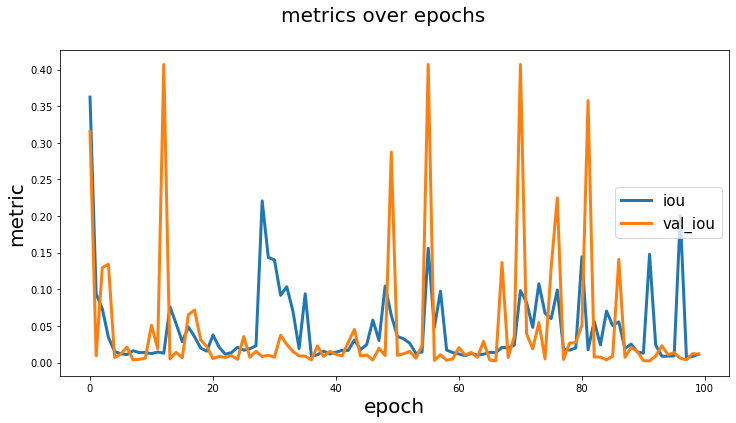

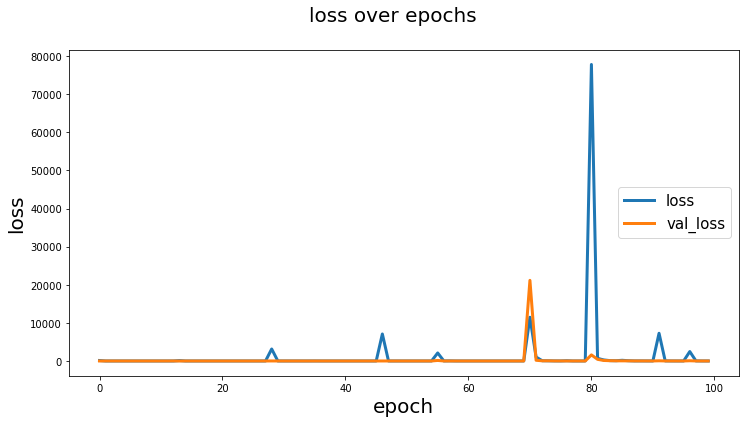

In [27]:
from keras_unet.utils import plot_segm_history

plot_segm_history(history)

In [28]:
y_pred = model.predict(X_val)

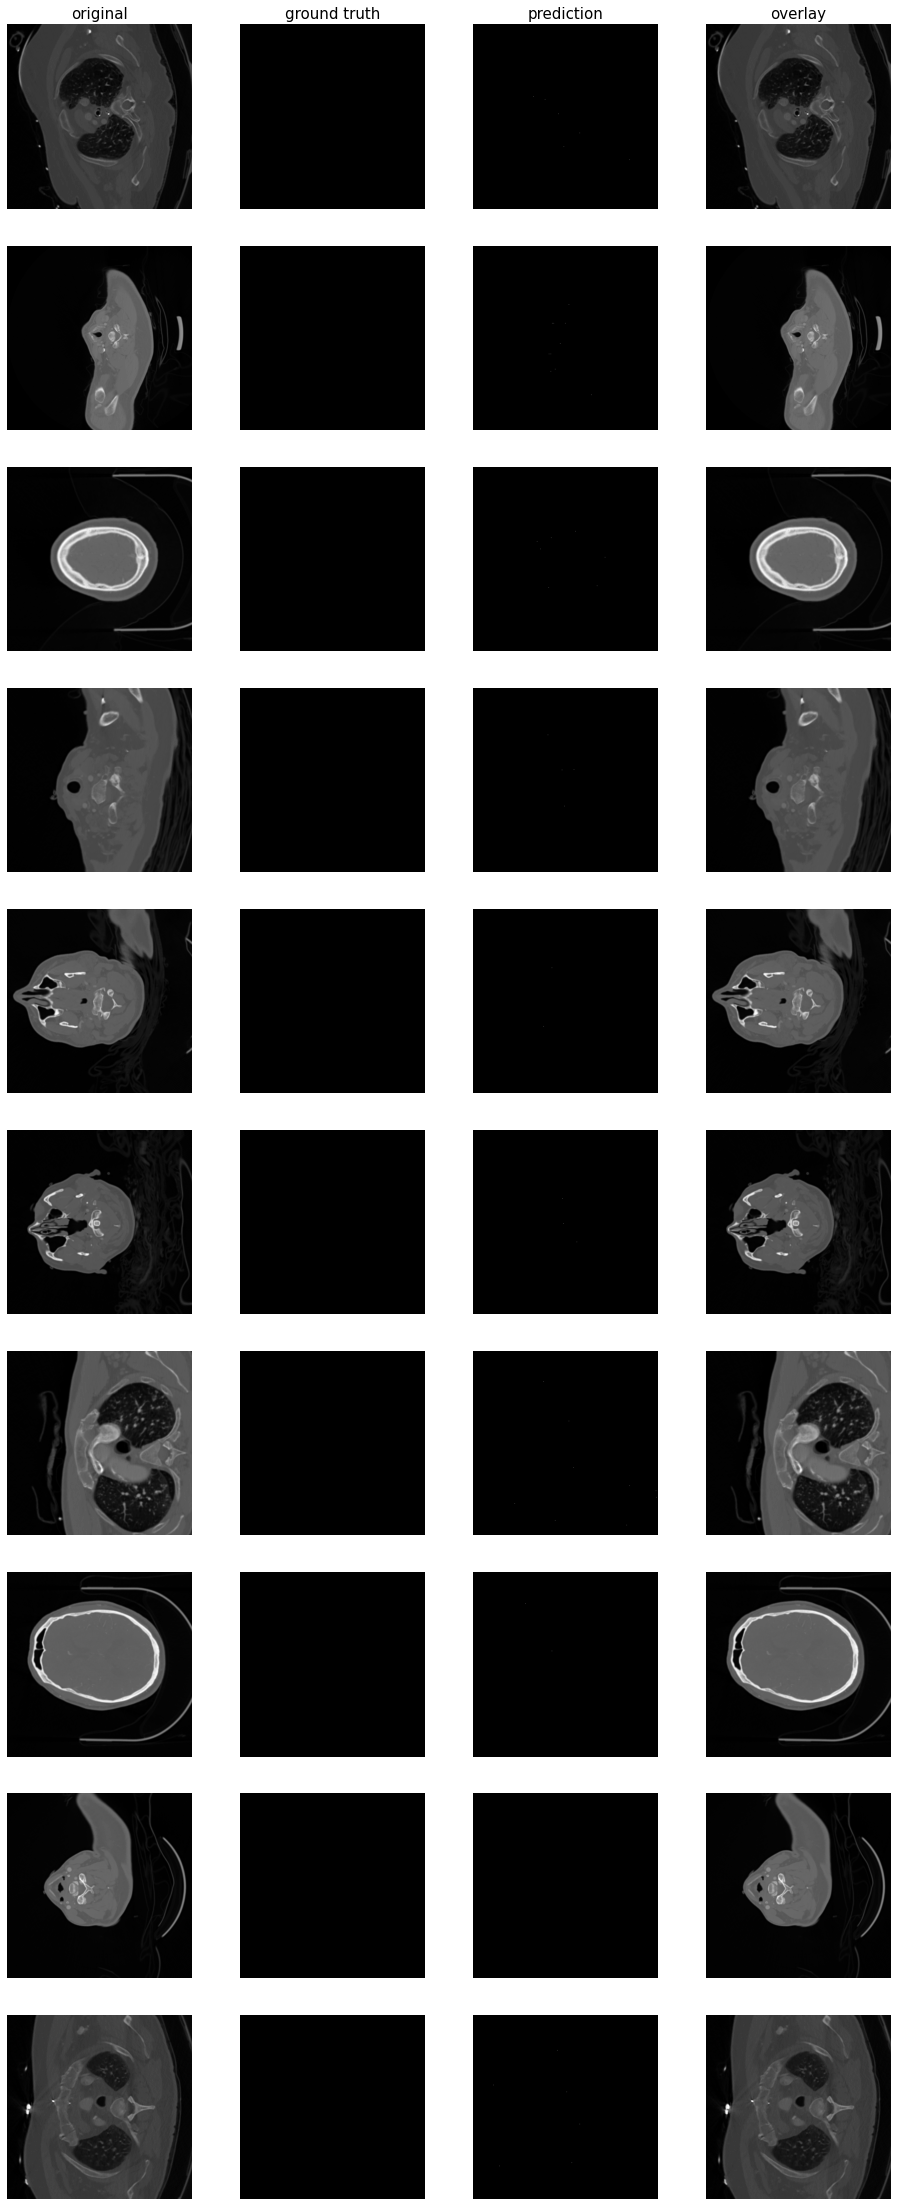

In [29]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=X_val, mask_imgs=y_val, pred_imgs=y_pred, nm_img_to_plot=10)

In [30]:
loss, iou, iou_thresholded = model.evaluate(X_val, y_val)

90/90 [==============================] - 45s 457ms/step - loss: 0.8585 - iou: 0.0047 - iou_thresholded: 0.0047
